<font size=6>**Deep Learning - Workshop: Diffusion Models**</font>


<font size=4>IMPORTANT: Don't forget to activate GPU!</font>

# POV: You need to model a distribution!

Let's suppose we are given some [unknown] **empirical distribution**, and we need to generate **mock data**.

<div>
   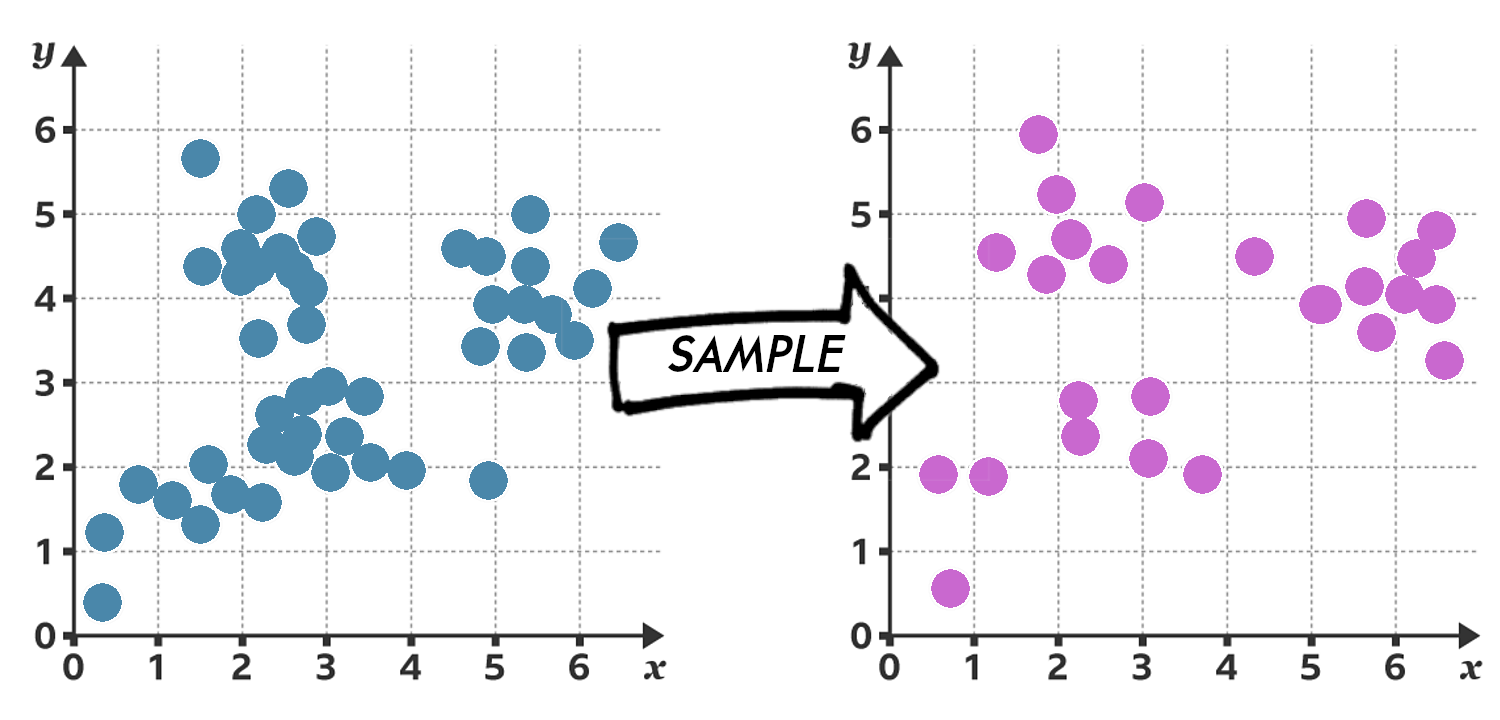
</div>

<table><tr>
    <td width=700>
        <center>
            <br>
            Figure 1. The sampling problem.  We need to sample some data (<i>right</i>) based on some empirical distribution (<i>left</i>).<br>
        </center>
    </td>
</tr></table>

<font size=3><u>**Example cases**</u><font>

E.g., you are:

- Running an **expensive simulation** $\rightarrow$ cannot generate _all_ the data analytically

- Dealing with **imbalanced data** $\rightarrow$ need more examples of the minority class

- Assessing **some statistics** $S$ $\rightarrow$ would like to "bootstrap" to obtain a distribution for $S$

<font size=3><u>**In-class discussion**</u><font>

What would you do, if you had to sample _pseudo_-real data given a dataset?
    
_Discuss a few mins with your teammate, then report.  This of possible pros and cons of your method._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
E.g. <b>KDE</b> (<b>Kernel Density Estimation</b>)
<br>
<code>sklearn.neighbors.KernelDensity</code>

We can think of KDE as a **smoothed distribution** (e.g. via Gaussians) of the data.    

<div>
   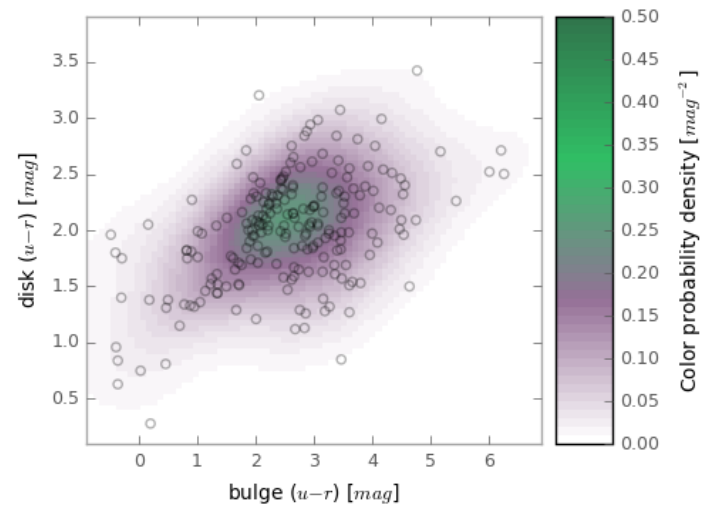
</div>

<table><tr>
    <td width=700>
        <center>
            <br>
            Figure 1b. An example of Kernel Density Estimation applied to a 2D color-color distribution.<br>
            (From <a herf="https://ui.adsabs.harvard.edu/abs/2021MNRAS.504.3831B/abstract">Bonfini et al. (2021)</a>)
        </center>
    </td>
</tr></table>

$\rightarrow$ From this **continuous** distribution we can now sample new datasets.
    
<b>PROS</b>:<br>
- Intuitive<br>
- Computationally quick
    
<b>CONS:</b><br>
- Parameteric
</details>

- - -
    
In general, **Parametric Models**:
- require **fine tuning** (_see hyperpar tuning_) 
- **difficult to define** for complex distributions

Are there non-parametric solutions to the problem? $\rightarrow$ **Generative Models**    

## Generative Models $vs$ Discriminative Models

What are **Generative Models**? $\rightarrow$ Better understood when defined in contrast to **Discriminative Models**.

Present a different paradigm to catalog ML models, based on which probability distribution they target.

https://developers.google.com/machine-learning/gan/generative

# Diffusion models

- Fancy image generator

- Theory from 2D example

# Building a diffusion model

In [1]:
import torch
import numpy as np
from diffusion import q_sample, posterior_q, Denoising, denoise_with_mu
from utils import pack_data, unpack_1d_data, scatter_pixels

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device in use [cpu/cuda]:', device)

Device in use [cpu/cuda]: cuda


## Import Data


In [16]:
import os
import wget
import pandas as pd

path_data = './data'
# path of data folder

path_to_data = path_data+"/BPT.csv"
# path/to/file to be created

link_data = "https://drive.google.com/uc?id=1Q9HGOECZhRVqbJw3sF4XoSBu6xmfFMo-"
# Original link: https://drive.google.com/file/d/1Q9HGOECZhRVqbJw3sF4XoSBu6xmfFMo-/view?usp=share_link
# - replace: "file/d/" with "uc?id="
# - remove: "/view?usp=share_link"

if not os.path.exists(path_data):
    os.makedirs(path_data)

if not os.path.exists(path_to_data):
    response = wget.download(link_data, path_to_data)

df_data = pd.read_csv(path_to_data)

# Limiting data:
#n_samples = 10000
#df_data = df_data.sample(n=n_samples, random_state=42)
frac_sampling = 0.02
df_data = df_data.groupby('Target_class', group_keys=False).apply(lambda x: x.sample(frac=frac_sampling))
# stratified sampling

display(df_data.head(5))
print(df_data.shape)

,D4000_N,log_sqrd_OIII,Target_class
46709,1.152497,1.123278,0
33813,1.364704,0.485923,0
19256,1.093412,1.869631,0
21568,1.183066,1.621984,0
33823,1.459666,0.436139,0


(1169, 3)


In [17]:
# Scaling:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_data[['D4000_N', 'log_sqrd_OIII']] = scaler.fit_transform(df_data[['D4000_N', 'log_sqrd_OIII']])

x = df_data['D4000_N'].values
y = df_data['log_sqrd_OIII'].values

## Scatter plot of data we will try to train the model to generate from random noise

/home/peblo/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


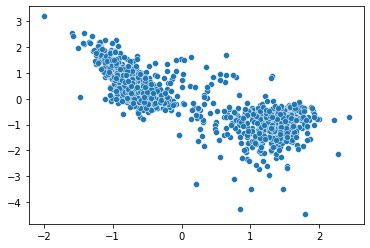

In [18]:
import seaborn as sns
ax = sns.scatterplot(x,y)

In [19]:
## Store the ax to plot the result later
y_ax = ax.get_ylim()
x_ax = ax.get_xlim()
axes = (x_ax,y_ax)

In [20]:
# send data to device
one_d_data = pack_data(x,y)
x_init = torch.tensor(one_d_data).to(torch.float32).to(device)

DATA_SIZE = len(x_init)

## Diffusion Parameters

In [21]:
beta_start = 0.0004#.0004
beta_end = .02#.02
num_diffusion_timesteps = 250

In [22]:
from operator import mul
from functools import reduce 

betas = np.linspace(beta_start ** 0.5, beta_end ** 0.5, num_diffusion_timesteps) ** 2
alphas = 1 - betas

# send parameters to device
betas = torch.tensor(betas).to(torch.float32).to(device)
alphas = torch.tensor(alphas).to(torch.float32).to(device)

# alpha_bar_t is the product of all alpha_ts from 0 to t
list_bar_alphas = [alphas[0]]
for t in range(1,num_diffusion_timesteps):
    list_bar_alphas.append(reduce(mul,alphas[:t]))
    
list_bar_alphas = torch.cumprod(alphas, axis=0).to(torch.float32).to(device)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

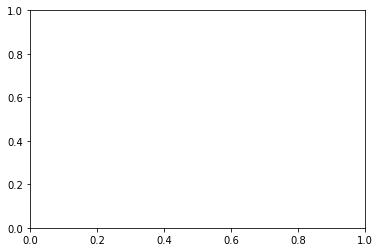

In [15]:
# From here:
#    https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb#scrollTo=oP-rFQUzdx9h
from matplotlib import pyplot as plt

plt.plot(list_bar_alphas ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - list_bar_alphas) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

## Training Procedure

In [23]:
import torch.nn as nn
import torch.optim as optim


training_steps_per_epoch = 50


criterion = nn.MSELoss()
denoising_model = Denoising(DATA_SIZE, num_diffusion_timesteps).to(device)
# disgusting hack to put embedding layer on 'device' as well, as it is not a pytorch module!
denoising_model.emb = denoising_model.emb.to(device)
optimizer = optim.AdamW(denoising_model.parameters())

### Run training

In [24]:
%%time
from tqdm import tqdm

losses = []
# list of losses, one per epoch

pbar = tqdm(range(50))
for epoch in pbar:  # loop over the dataset multiple times
    
    cum_loss = 0.0
    # sum of losses over the sampled timesteps _within_ an epoch
    
    # sample a bunch of timesteps
    Ts = np.random.randint(1,num_diffusion_timesteps, size=training_steps_per_epoch)
    for _, t in enumerate(Ts):
                
        # produce corrupted sample
        q_t = q_sample(x_init, t, list_bar_alphas, device)
                
        # calculate the mean and variance of the posterior forward distribution q(x_t-1 | x_t,x_0)
        mu_t, cov_t = posterior_q(x_init, q_t, t, alphas, list_bar_alphas, device)
        # get just first element from diagonal of covariance since they are all equal
        sigma_t = cov_t[0][0]
        # zero the parameter gradients
        optimizer.zero_grad()
  
        mu_theta = denoising_model(q_t , t)
        loss = criterion(mu_t, mu_theta)
        loss.backward()
        optimizer.step()
        cum_loss += loss.detach()
    
    losses.append(cum_loss/training_steps_per_epoch)
    # average loss for the current epoch
    
    pbar.set_description('Epoch: {} Loss: {}'.format(epoch, losses[-1]))
print('Finished Training')

Epoch: 49 Loss: 0.40214937925338745: 100%|██████████| 50/50 [04:14<00:00,  5.08s/it]

Finished Training
CPU times: user 7min 13s, sys: 814 ms, total: 7min 14s
Wall time: 4min 14s


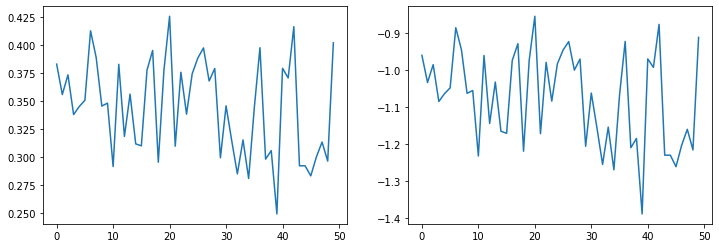

In [31]:
import matplotlib.pyplot as plt

if device != 'cpu':
    losses = [loss.detach().cpu().numpy() for loss in losses]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

## Reverse-Diffuse one Sample of Noise!

In [11]:
from tqdm import tqdm 
data = torch.distributions.MultivariateNormal(loc=torch.zeros(DATA_SIZE),covariance_matrix=torch.eye(DATA_SIZE)).sample().to(device)

for t in tqdm(range(0,num_diffusion_timesteps)):
    data = denoise_with_mu(denoising_model,data,num_diffusion_timesteps-t-1, alphas, list_bar_alphas, DATA_SIZE, device)

  0%|          | 0/250 [00:00<?, ?it/s]


NameError: name 'denoising_model' is not defined

/home/peblo/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

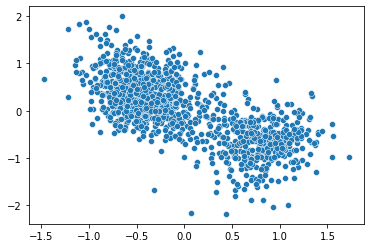

In [15]:
data = data.detach().cpu().numpy()
x_new, y_new = unpack_1d_data(data)

import seaborn as sns
sns.scatterplot(x_new,y_new)

### Create an AWESOME HD 24fps GIF

In [16]:
data = torch.distributions.MultivariateNormal(loc=torch.zeros(DATA_SIZE),covariance_matrix=torch.eye(DATA_SIZE)).sample().to(device)

In [ ]:
import numpy as np
from celluloid import Camera
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()
camera = Camera(fig)

# animation draws one data point at a time
for d in range(1, num_diffusion_timesteps):
    data = denoise_with_mu(denoising_model,data,num_diffusion_timesteps-d, alphas, list_bar_alphas, DATA_SIZE, device)
    data_plot = data.detach().cpu().numpy()
    x_new, y_new = unpack_1d_data(data_plot)
    graph = sns.scatterplot(x=x_new,y=y_new,palette=['green'])
    graph.set_xlim(axes[0])
    graph.set_ylim(axes[1])
    camera.snap()

anim = camera.animate(blit=False)
anim.save('output.gif',fps=24, dpi=120)